In [1]:
import cv2

import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

sys.path.append("/root/workspace/DCLA-UNet")


# print(sys.path)
from src.datasets.transforms import CenterCrop3D, Compose, FrontGroundNormalize, RandomCrop3D, ToTensor
from src.nnArchitecture.nets.dcla_nets import DCLA_UNet_NoRes_250607, ResUNetBaseline_S, SLK_MSF_DCLA_NoRes_UNet_250607
# from src.optimized_inference import load_data
from src.datasets.BraTS21 import BraTS21_3D

DataLoader = torch.utils.data.DataLoader

Importing from timm.models.layers is deprecated, please import via timm.layers


已加载测试数据: 1
torch.Size([1, 4, 128, 128, 128])


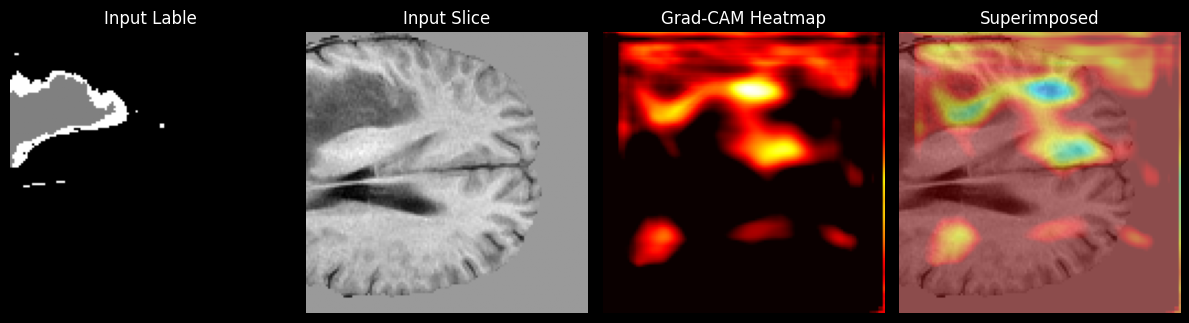

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        """
        GradCAM 可视化工具
        Args:
            model: 加载的模型
            target_layer: 目标卷积层（如 model.Conv4[1]）
        """
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # 注册钩子
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate(self, input_tensor, target_class=None):
        """
        生成 Grad-CAM 热力图
        Args:
            input_tensor: 输入张量 (1, C, D, H, W)
            target_class: 目标类别 (None 表示最大概率类别)
        Returns:
            heatmap: Grad-CAM 热力图 (H, W)
        """
        self.model.eval()
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # 反向传播
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)
        
        # 计算权重
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3, 4])
        
        # 加权特征图
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :, :] *= pooled_gradients[i]
        
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = torch.relu(heatmap)  # 应用 ReLU
        
        # 归一化
        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
        
        return heatmap.cpu().numpy()

def visualize_gradcam(model, label, input_volume, layer_name, slice_idx=None, target_class=None):
    """
    可视化 3D 体积的 Grad-CAM
    Args:
        model: 模型实例
        input_volume: 输入体积 (1, C, D, H, W)
        layer_name: 目标层名称 (如 'Conv4')
        slice_idx: 切片索引 (None 表示中间切片)
        target_class: 目标类别
    """
    # 获取目标层
    target_layer = getattr(model, layer_name)
    if isinstance(target_layer, nn.Sequential):
        target_layer = target_layer[-1].conv_[0]  # 获取实际卷积层
    
    # 初始化 GradCAM
    gradcam = GradCAM(model, target_layer)
    
    # 选择切片
    if slice_idx is None:
        slice_idx = input_volume.shape[2] // 2
    
    # 生成热力图
    heatmap = gradcam.generate(input_volume, target_class)
    
    # 选择同一切片
    heatmap_slice = heatmap[slice_idx]
    input_slice = input_volume[0, 0, slice_idx].cpu().numpy()  # 取第一个通道
    label_slice = label[0, slice_idx].cpu().numpy()
    
    # 调整热力图大小匹配输入
    heatmap_resized = cv2.resize(heatmap_slice, (input_slice.shape[1], input_slice.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # 应用颜色映射
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    # 叠加热力图到原图
    img_normalized = np.uint8(255 * (input_slice - input_slice.min()) / 
                             (input_slice.max() - input_slice.min()))
    img_colored = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2BGR)
    superimposed = cv2.addWeighted(img_colored, 0.5, heatmap_colored, 0.5, 0)
    
    # 可视化
    plt.figure(figsize=(12, 6))
    
    plt.subplot(141)
    plt.title("Input Lable")
    plt.imshow(label_slice, cmap='gray')
    plt.axis('off')
    
    plt.subplot(142)
    plt.title("Input Slice")
    plt.imshow(input_slice, cmap='gray')
    plt.axis('off')
    
    plt.subplot(143)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_slice, cmap='hot')
    plt.axis('off')
    
    plt.subplot(144)
    plt.title("Superimposed")
    plt.imshow(superimposed)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def load_data(test_csv, local_train=False, test_length=10, batch_size=1, num_workers=4):
    """加载数据集"""
    TransMethods_test = Compose([
        RandomCrop3D(size=(128, 128, 128)),
        FrontGroundNormalize(),
        ToTensor(),
    ])

    test_dataset = BraTS21_3D(
        data_file=test_csv,
        transform=TransMethods_test,
        local_train=local_train,
        length=test_length,
    )
    
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True  # 减少 worker 初始化时间
    )
    
    print(f"已加载测试数据: {len(test_loader)}")
    return test_loader


# 使用示例
if __name__ == "__main__":
    # 初始化模型
    model = DCLA_UNet_NoRes_250607(in_channels=4, out_channels=4)
    
    # 加载预训练权重 (需要先训练模型)
    # model.load_state_dict(torch.load('path/to/weights.pth'))
    csv_file = '/root/workspace/BraTS_Solution/data/test.csv'
    
    test_loader = load_data(csv_file, batch_size=1, num_workers=4, local_train=True, test_length=1)
    
    input_volume, label = next(iter(test_loader))
    
    print(input_volume.shape)
    
    # 创建随机输入 (模拟实际数据)
    # input_volume = torch.randn(1, 4, 128, 128, 128)  # (B, C, D, H, W)
    
    # 可视化 Grad-CAM
    visualize_gradcam(
        model=model,
        label=label,
        input_volume=input_volume,
        layer_name='outc',  # 目标层名称
        slice_idx=80,        # 选择深度切片
        target_class=1       # 目标类别
    )

已加载测试数据: 1
torch.Size([1, 4, 128, 128, 128])


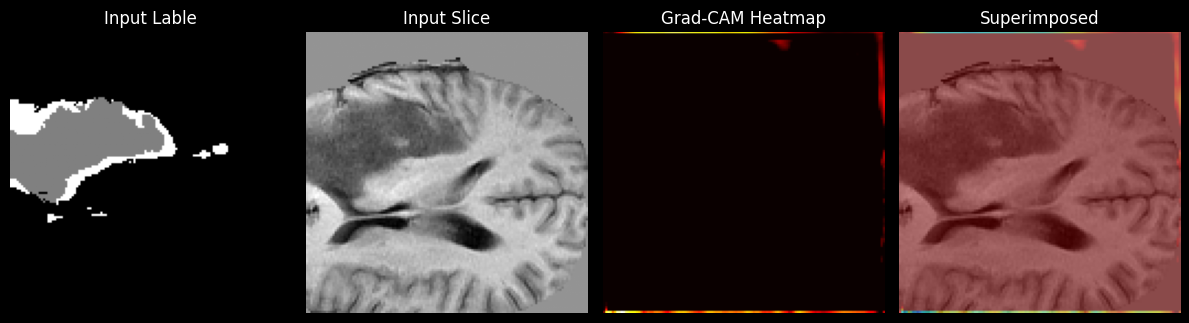

In [3]:
if __name__ == "__main__":
    # 初始化模型
    model = ResUNetBaseline_S(in_channels=4, out_channels=4)
    
    # 加载预训练权重 (需要先训练模型)
    # model.load_state_dict(torch.load('path/to/weights.pth'))
    csv_file = '/root/workspace/BraTS_Solution/data/test.csv'
    
    test_loader = load_data(csv_file, batch_size=1, num_workers=4, local_train=True, test_length=1)
    
    input_volume, label = next(iter(test_loader))
    
    print(input_volume.shape)
    
    # 创建随机输入 (模拟实际数据)
    # input_volume = torch.randn(1, 4, 128, 128, 128)  # (B, C, D, H, W)
    
    # 可视化 Grad-CAM
    visualize_gradcam(
        model=model,
        label=label,
        input_volume=input_volume,
        layer_name='outc',  # 目标层名称
        slice_idx=80,        # 选择深度切片
        target_class=1       # 目标类别s
    )